## Install and import depdencies 

In [ ]:
!conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

In [ ]:
!conda install ultralytics
!pip install --upgrade ultralytics

In [2]:
from ultralytics import YOLO
import torch
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Prep training materials

In [ ]:
import os
import shutil
import random

Please make sure all images are labeled using YOLO format.

INSTRUCTIONS:
1. Create a folder named "data" OUTSIDE of the local repo. This folder will contain all your data.
2. Create a subdirectory inside the data folder and add one folder named "unsplit". Add your images and labels folders to this subdirectory.
   I have included an exmaple directory inside the RSYOLOV8 folder. This is how your data folder should be set up before running the next part of the code.
3. Please go into the config.yaml file and set the "path" variable to the ABSOLUTE PATH of the data folder.
   

In [ ]:
# Set the path to the data folder below as well.
data_dir = "D:/RecieptScanner\data"

In [ ]:
# Define paths
unsplit_dir = os.path.join(data_dir, 'unsplit')
images_dir = os.path.join(unsplit_dir, 'images')
labels_dir = os.path.join(unsplit_dir, 'labels')

In [ ]:
# New directories
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
# Create new directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'labels'), exist_ok=True)

In [ ]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [ ]:
# get unsplit images and labels
images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
labels = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

In [ ]:
# Ensure there is a label for each image
images = [img for img in images if f'{os.path.splitext(img)[0]}.txt' in labels]

In [ ]:
random.shuffle(images)

In [ ]:
# Calculate split sizes
total_images = len(images)
train_size = int(total_images * train_ratio)
val_size = int(total_images * val_ratio)
test_size = total_images - train_size - val_size

In [ ]:
# Split images and labels
train_images = images[:train_size]
val_images = images[train_size:train_size + val_size]
test_images = images[train_size + val_size:]

In [ ]:
# Function to move files to appropriate directories
def move_files(file_list, source_img_dir, source_lbl_dir, target_dir):
    for file_name in file_list:
        img_source_path = os.path.join(source_img_dir, file_name)
        lbl_source_path = os.path.join(source_lbl_dir, f'{os.path.splitext(file_name)[0]}.txt')
        
        img_target_path = os.path.join(target_dir, 'images', file_name)
        lbl_target_path = os.path.join(target_dir, 'labels', f'{os.path.splitext(file_name)[0]}.txt')
        
        shutil.copy(img_source_path, img_target_path)
        shutil.copy(lbl_source_path, lbl_target_path)

In [ ]:
# Move files to train, val, test directories
move_files(train_images, images_dir, labels_dir, train_dir)
move_files(val_images, images_dir, labels_dir, val_dir)
move_files(test_images, images_dir, labels_dir, test_dir)

# You are now ready to train!

## Select model architecture

In [ ]:
model = YOLO('yolov8n.yaml')  # 'yolov8n.yaml' for untrained or 'yolov8s.pt' for pretrained weights

## Train the model

In [ ]:
# data: Specifies the path to the dataset configuration file
# imgsz: Sets the image size
# batch: Sets the batch size
# epochs: Sets the number of epochs
# workers: Sets the number of data loader workers ( i have no idea what this does )
#model.train(data='config.yaml', workers=2, iou=0.5, 
#    epochs=1000, batch= 16, imgsz=640, optimizer='SGD', weight_decay=0.0005, momentum=0.9,)
model.train(data="config.yaml", epochs=500, workers=2)
model.export(format="onnx")

## Export as tflite

In [ ]:

model = YOLO('trained models/best.pt')

model.export(format="onnx")

In [ ]:
model2 = YOLO('yolov8s.pt')
model2.train(data="config.yaml", epochs=2000, workers=2)
model2.export(format="onnx")

## Testing

In [3]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os


0: 640x288 2 items, 1 total, 19.1ms
Speed: 3.5ms preprocess, 19.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 288)
[     104.36        1703      1705.1      1804.2] hellO
[      125.2      1184.1      1711.6      1275.1] hellO
[     122.13      1441.5      1711.4      1552.3] hellO


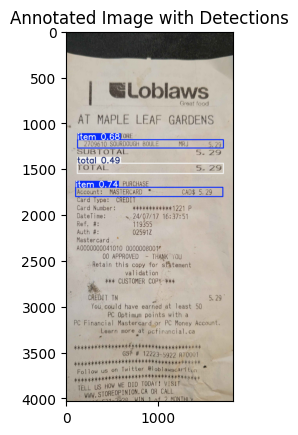

In [8]:
# absolute path
%matplotlib inline
model = YOLO('D:/RecieptScanner/reciept-scanner/RSYOLOV8/testModels/bestonnx.pt')
img = cv2.imread('D:/RecieptScanner/reciept-scanner/RSYOLOV8/testModels/images/reciept.jpg')
results = model(img, conf=0.4, iou=0.4)

for result in results:
    boxes = result.boxes.cpu().numpy()
    
    # convert into cv2 rectangle
    for xyxy in boxes.xyxy:
        print(xyxy, "hellO")
annotated_img = results[0].plot()
# Save the annotated image
if os.path.exists('annotated_image.jpg'):
        os.remove('annotated_image.jpg')
cv2.imwrite('annotated_image.jpg', results[0].plot())

# Load and display the saved image using matplotlib
plt.figure()
annotated_img = cv2.imread('annotated_image.jpg')
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.title("Annotated Image with Detections")
plt.show()

## Onnx test

In [ ]:
!pip install onnxruntime

[{'bbox': [333.0837707519531, 171.1197509765625, 323.7587890625, 527.8651123046875], 'score': 645.07568359375, 'class': 1}, {'bbox': [295.8455505371094, 299.54656982421875, 623.5193481445312, 632.363525390625], 'score': 640.2606201171875, 'class': 0}, {'bbox': [135.9381866455078, 153.96157836914062, 408.3193664550781, 439.06439208984375], 'score': 542.9027099609375, 'class': 2}, {'bbox': [374.24513244628906, 199.25503540039062, 422.8481140136719, 479.15679931640625], 'score': 490.93841552734375, 'class': 0}, {'bbox': [8.892547607421875, 6.435150146484375, 16.22967529296875, 19.70611572265625], 'score': 478.8399963378906, 'class': 2}, {'bbox': [119.548095703125, 108.54939270019531, 187.45709228515625, 189.04367065429688], 'score': 464.21875, 'class': 2}, {'bbox': [273.7915496826172, 268.24595642089844, 399.1678771972656, 307.1294250488281], 'score': 460.7698059082031, 'class': 1}]
7


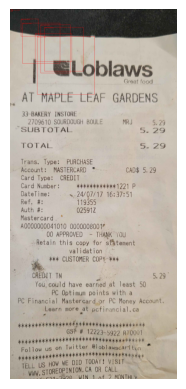

In [18]:
import onnxruntime as ort
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import tensorflow as tf

# Running prediction on ONNX using method 1 (javascript similarity)

def preprocess_image(image_path, target_size):
    image = Image.open(image_path).convert('RGB')
    image_resized = image.resize(target_size, Image.LANCZOS)
    image_array = np.array(image_resized) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    image_array = np.transpose(image_array, (0, 3, 1, 2))
    return image_array.astype(np.float32), image

def run_onnx_model(model_path, image_array):
    session = ort.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    result = session.run([output_name], {input_name: image_array})
    return result

def onnx_nms(output, image_size):
    num_detections = 8400
    output_tensor = output.flatten()
    output_array = output_tensor.tolist()

    tf_boxes = []
    scores = []
    classes = []

    for i in range(num_detections):
        offset = i * 7
        classes_scores = output_array[offset + 4: offset + 7]
        max_score = max(classes_scores)
        max_class_index = classes_scores.index(max_score)

        if max_score >= 0.25:
            box = [
                output_array[offset] - 0.5 * output_array[offset + 2], # x
                output_array[offset + 1] - 0.5 * output_array[offset + 3], # y
                output_array[offset + 2], # width
                output_array[offset + 3], # height
            ]

            tf_boxes.append(box)
            scores.append(max_score)
            classes.append(max_class_index)

    max_output_size = 100
    iou_threshold = 0.1
    score_threshold = 400.0

    tf_boxes_tensor = tf.convert_to_tensor(tf_boxes)
    scores_tensor = tf.convert_to_tensor(scores)
    
    selected_indices = tf.image.non_max_suppression(
        tf_boxes_tensor, scores_tensor, max_output_size, iou_threshold, score_threshold
    )

    nms_boxes = []
    for index in selected_indices.numpy():
        nms_boxes.append({
            'bbox': tf_boxes[index],
            'score': scores[index],
            'class': classes[index]
        })
    print(nms_boxes)
    print(len(nms_boxes))
    return nms_boxes

def draw_bounding_boxes(image, bounding_boxes):
    draw = ImageDraw.Draw(image)
    for bbox in bounding_boxes:
        box = bbox['bbox']
        draw.rectangle([(box[0], box[1]), (box[0] + box[2], box[1] + box[3])], outline="red", width=2)
        draw.text((box[0], box[1]), f"Class: {bbox['class']} Score: {bbox['score']:.2f}", fill="red")
    return image

def main(image_path, model_path, target_size):
    preprocessed_image, original_image = preprocess_image(image_path, target_size)
    model_output = run_onnx_model(model_path, preprocessed_image)
    detection_results = onnx_nms(model_output[0], original_image.size)

    image_with_boxes = draw_bounding_boxes(original_image, detection_results)
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'D:/RecieptScanner/reciept-scanner/RSYOLOV8/testModels/images/reciept.jpg'
model_path = 'D:/RecieptScanner/reciept-scanner/RSYOLOV8/testModels/bestonnx.onnx'
target_size = (640, 640)

main(image_path, model_path, target_size)

In [19]:
import numpy as np
import onnxruntime as ort
from PIL import Image, ImageDraw
import cv2

# GPT Procedure

# Function to perform Non-Maximum Suppression
def non_max_suppression(prediction, conf_thresh=0.4, iou_thresh=0.1):
    boxes = prediction[:, :4]  # Extract bounding boxes
    scores = prediction[:, 4] * prediction[:, 5]  # Compute scores
    classes = prediction[:, 6]  # Extract class ids

    # Convert boxes to corner coordinates
    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

    # Apply score threshold
    indices = scores > conf_thresh
    boxes, scores, classes = boxes[indices], scores[indices], classes[indices]

    # Apply NMS
    indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), conf_thresh, iou_thresh)
    if len(indices) > 0:
        indices = indices.flatten()
        boxes, scores, classes = boxes[indices], scores[indices], classes[indices]

    return boxes, scores, classes

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, bounding_boxes):
    draw = ImageDraw.Draw(image)
    for bbox in bounding_boxes:
        box = bbox['bbox']
        draw.rectangle([(box[0], box[1]), (box[0] + box[2], box[1] + box[3])], outline="red", width=2)
        draw.text((box[0], box[1]), f"Class: {bbox['class']} Score: {bbox['score']:.2f}", fill="red")
    return image

# Main function to run inference
def main(image_path, model_path, target_size):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    image_resized = image.resize(target_size)
    image_np = np.array(image_resized).astype(np.float32)
    image_np = np.transpose(image_np, (2, 0, 1))  # Change to (C, H, W) format
    image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension
    image_np /= 255.0  # Normalize to [0, 1]

    # Load the ONNX model
    ort_session = ort.InferenceSession(model_path)
    
    # Run inference
    outputs = ort_session.run(None, {ort_session.get_inputs()[0].name: image_np})

    # Apply NMS
    prediction = outputs[0].reshape(-1, 7)  # Reshape to (8400, 7)
    boxes, scores, classes = non_max_suppression(prediction)

    # Prepare bounding boxes for drawing
    bounding_boxes = [{'bbox': [box[0], box[1], box[2] - box[0], box[3] - box[1]], 'class': int(cls), 'score': score}
                      for box, cls, score in zip(boxes, classes, scores)]
    
    # Draw bounding boxes on the image
    result_image = draw_bounding_boxes(image, bounding_boxes)
    
    return result_image

# Example usage
image_path = 'D:/RecieptScanner/reciept-scanner/RSYOLOV8/testModels/images/reciept.jpg'
model_path = 'D:/RecieptScanner/reciept-scanner/RSYOLOV8/testModels/bestonnx.onnx'
target_size = (640, 640)

result_image = main(image_path, model_path, target_size)
result_image.show()
